In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
import pandas as pd
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Privug for Genomic Data: A Case Study on the TAS2R38 and TAS2R16 receptor genes

This notebook demonstrates the use of the [privug method](https://link.springer.com/chapter/10.1007/978-3-030-88428-4_21) to quantify privacy risks on genetic data. In particular, we look into the probability of guessing the ethincity of an individual by observing a taste receptor phenotype and polygenic risk score.

This is an accompanying notebook to the paper "Privacy with Good Taste: A Case Study in Quantifying Data Privacy in Genetic Scores" by _Raúl Pardo, Willard Rafnsson, Gregor Steinhorn, Denis Lavrov, Thomas Lumley, Christian W. Probst, Ilze Ziedins, and Andrzej Wasowski._

The notebook contains additional analysis not included in the paper.

## Data

Populations genetics and phenotype association for TAS2R38 were retrieve from this paper [_"Global diversity in the TAS2R38 bitter taste receptor: revisiting a classic evolutionary Proposal"_](https://www.nature.com/articles/srep25506), and for TAS2R16 from this paper ["Positive Selection on a High-Sensitivity Allele of the Human Bitter-Taste Receptor TAS2R16"](https://www.sciencedirect.com/science/article/pii/S0960982205006779)

Genetic scores were derived by Gregor Steinhorn who is a Molecular Biologist turned Commercialisation Partner based on EC50 values from this paper ["Genetic, functional, and phenotypic diversity in TAS2R38-mediated bitter taste perception"](https://pubmed.ncbi.nlm.nih.gov/23632915/).

In [3]:
tas2r38_data=(np.array([[50.76, 42.70, 2.48, 0.32, 0.18, 0.07, 3.39, 0.10],
                        [50.76, 35.18, 0.61, 0.08, 0.00, 0.15, 13.22, 0.00],
                        [64.51, 35.31, 0.00, 0.17, 0.00, 0.00, 0.00, 0.00],
                        [45.66, 49.22, 3.56, 0.49, 0.32, 0.03, 0.55, 0.17],
                        [68.61, 26.69, 2.26, 0.00, 0.00, 0.19, 2.26, 0.00]])/100)[1:]

tas2r16_data=np.array([
    [0.151111111, 0.835555556, 0.013333333],
    [0.001153403, 0.630911188, 0.367935409],
    [0.00, 0.681034483, 0.318965517],
    [0.00, 0.810526316, 0.189473684],
])


# Constants for convenience
## ethnicities
AFRICAN=0
ASIAN=1
EUROPEAN=2
AMERICAN=3

ETHNICITIES = [AFRICAN,ASIAN,EUROPEAN,AMERICAN]
ethnicity_names = ["African", "Asian", "European", "American"]

## TAS2R38 haplotypes
PAV=0
AVI=1
AAV=2
AVV=3
PAI=4
PVI=5
AAI=6
PVV=7

#TAS2R16 haplotypes
HAPCD=0
HAPA=1
HAPB=2

TASTER=0
NONTASTER=1

# haplotype names
tas2r38_names = ["PAV", "AVI", "AAV", "AVV", "PAI", "PVI", "AAI", "PVV"]
tas2r16_names = ["HAP-CD", "HAP-A", "HAP-B"]

# genotypes
from itertools import permutations, combinations, chain
tas2r38_genotypes=list(chain(*[[(j, i) for i in range(j, 8)] for j in range(0, 8)]))
tas2r16_genotypes=list(chain(*[[(j, i) for i in range(j, 3)] for j in range(0, 3)]))
# genotype names
def gen2name_tas2r38(genotype): 
    return tas2r38_names[genotype[0]]+"/"+tas2r38_names[genotype[1]]

def gen2name_tas2r16(genotype):
    return tas2r16_names[genotype[0]]+"/"+tas2r16_names[genotype[1]]

# display(list(zip(map(gen2name_tas2r38, tas2r38_genotypes), tas2r38_genotypes)))

tas2r38_gw = 1.8
tas2r16_gw = 1.0

tas2r38_scores = [4.547522064, 0.06644, 1.41863513, 1, 3.996122007, 3.033624441, 1.145344495, 1] # No score for AVV and PVV, Gregor didn't provide, need to reweight the population genetics data.
tas2r38_gt = map(lambda x: tas2r38_scores[x[0]]+ tas2r38_scores[x[1]], tas2r38_genotypes)
tas2r38_gen2gt = dict(zip(tas2r38_genotypes, tas2r38_gt))
# display(tas2r38_gen2gt)

# display(list(map(gen2name_tas2r16, tas2r16_genotypes)))
tas2r16_gt = [0, 0.5, 0.5, 1, 1, 1]
tas2r16_gen2gt = dict(zip(tas2r16_genotypes, tas2r16_gt))

## PyMC3 model

We are interested in measuring the effectiveness of an anonymization program in protecting the user ethnicity. To this end, we consider a program that takes a set of genotypes and anonymises them by translating them to either phenotypes or a form of genetic score. 

NOTE: In the paper, in the paper we have simplified version the code of the program for illustrative purposes. Here we use advanced features of python programming to make them applicable families of genes other than TAS2R38 and TAS2R16. Also, round the output to 2 decimal points directly on the posterior trace (instead of directly in the program).


In [3]:
with pm.Model() as genomics:
    
    @theano.compile.ops.as_op(itypes=[tt.lscalar],otypes=[tt.dvector])
    def tas2r38_dist(ethnicity):
        return tas2r38_data[ethnicity]
    
    @theano.compile.ops.as_op(itypes=[tt.lscalar],otypes=[tt.dvector])
    def tas2r16_dist(ethnicity):
        return tas2r16_data[ethnicity]
    
    # The "anonymization" function
    @theano.compile.ops.as_op(itypes=[tt.lvector],otypes=[tt.lscalar])
    def tas2r38_anon(genotype):
        return np.array((genotype == [AVI, AVI]).all(), dtype=np.int64) # 0: taster, 1: non-taster
    @theano.compile.ops.as_op(itypes=[tt.lvector],otypes=[tt.lscalar])
    def tas2r16_anon(genotype):
        return np.array((genotype == [HAPCD, HAPCD]).all(), dtype=np.int64) # 0: taster, 1: non-taster
    
    @theano.compile.ops.as_op(itypes=[tt.lvector, tt.lvector], otypes=[tt.fscalar])
    def linear_gs(tas2r38_genotype, tas2r16_genotype):
        return np.float32(tas2r38_gw*tas2r38_gen2gt[tuple(tas2r38_genotype)] + tas2r16_gw*tas2r16_gen2gt[tuple(tas2r16_genotype)])

    
    @theano.compile.ops.as_op(itypes=[tt.fscalar], otypes=[tt.fscalar])
    def nonlinear_gs(linear_gs):
        sf1 = 1.2
        sf2 = 5
        return np.float32(linear_gs * (sf1 ** linear_gs / sf2))
        
    @theano.compile.ops.as_op(itypes=[tt.fscalar, tt.dscalar], otypes=[tt.fscalar])
    def noise_gs(nonlinear_gs, noise):
        return np.float32(nonlinear_gs * noise)
        
    
    N = 1
    ethnicity = [pm.Categorical('ethnicity_'+str(i),p=[0.25,0.25,0.25,0.25]) for i in range(0,N)] # no assumptions about ethnicity
    tas2r38_genotype = [pm.Deterministic('tas2r38_genotype_'+str(i), pm.Categorical('tas2r38_diplotype_'+str(i),p=tas2r38_dist(ethnicity[i]), shape=(2)).sort(axis=0)) for i in range(0,N)]
    tas2r38_phenotype = [pm.Deterministic('tas2r38_phenotype_'+str(i), tas2r38_anon(tas2r38_genotype[i])) for i in range(0,N)]
    
    tas2r16_genotype = [pm.Deterministic('tas2r16_genotype_'+str(i), pm.Categorical('tas2r16_diplotype_'+str(i),p=tas2r16_dist(ethnicity[i]), shape=(2)).sort(axis=0)) for i in range(0,N)]
    tas2r16_phenotype = [pm.Deterministic('tas2r16_phenotype_'+str(i), tas2r16_anon(tas2r16_genotype[i])) for i in range(0,N)]
    
    linear_anon = [pm.Deterministic('linear_gs_'+str(i), linear_gs(tas2r38_genotype[i], tas2r16_genotype[i])) for i in range(0,N)]
    nonlinear_anon = [pm.Deterministic('nonlinear_gs_'+str(i), nonlinear_gs(linear_anon[i])) for i in range(0,N)]
    
    [pm.Deterministic('noise05_gs_'+str(i),  noise_gs(nonlinear_anon[i], pm.Normal('noise05_'+str(i),mu=1, sigma=0.05))) for i in range(0,N)]
    [pm.Deterministic('noise_gs_'+str(i),  noise_gs(nonlinear_anon[i], pm.Normal('noise_'+str(i),mu=1, sigma=0.1))) for i in range(0,N)]
    [pm.Deterministic('noise2_gs_'+str(i),  noise_gs(nonlinear_anon[i], pm.Normal('noise2_'+str(i),mu=1, sigma=0.2))) for i in range(0,N)]

We sample a large trace (see the end of the notebook for convergence diagnosis)

In [4]:
## load trace from memory
trace = az.from_netcdf('trace.netcdf')

## sample a new trace
# with genomics:
#     trace=pm.sample(100000, tune=50000, return_inferencedata=True)

In [5]:
## save trace in memory
# trace.to_netcdf('trace.netcdf')

'trace.netcdf'

# Joint distribution for each ethnicity and genotype combination (prior attacker knowledge)

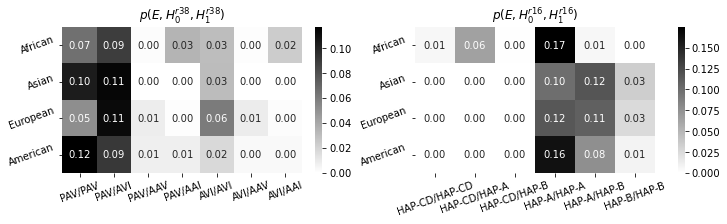

In [5]:
tas2r38_nonzero=[[PAV, PAV], [PAV, AVI], [PAV, AAV], [PAV, AAI], [AVI, AVI], [AVI, AAV], [AVI, AAI]]
fig,ax=plt.subplots(1,2,figsize=(10,3),constrained_layout = True);

sns.heatmap([[np.mean((trace.posterior['ethnicity_'+str(0)][:,:].values==j) & (trace.posterior['tas2r38_genotype_'+str(0)][:,:].values==i).all(axis=2)) for i in tas2r38_nonzero] for j in range(0,4)],
            annot=True,fmt=".2f",cmap="gray_r",ax=ax[0])
ax[0].set_title('$p(E,H^{r38}_0,H^{r38}_1)$')
ax[0].set_yticklabels(['African','Asian','European','American'],rotation=20)
ax[0].set_xticklabels(list(map(gen2name_tas2r38, tas2r38_nonzero)), rotation=20)

sns.heatmap([[np.mean((trace.posterior['ethnicity_'+str(0)][:,:].values==j) & (trace.posterior['tas2r16_genotype_'+str(0)][:,:].values==i).all(axis=2)) for i in tas2r16_genotypes] for j in range(0,4)],
            annot=True,fmt=".2f",cmap="gray_r",ax=ax[1])
ax[1].set_title('$p(E,H^{r16}_0,H^{r16}_1)$')
ax[1].set_yticklabels(['African','Asian','European','American'],rotation=20)
ax[1].set_xticklabels(list(map(gen2name_tas2r16, tas2r16_genotypes)), rotation=20)

plt.savefig('figures/prior.pdf')


# Linear Genetic Score
Despite being a float, it is actually discrete. Each column is a discrete score, whose height is distribution density within the population. The X-axis labels are rounded to 2 decimal points only for representation.purposes.

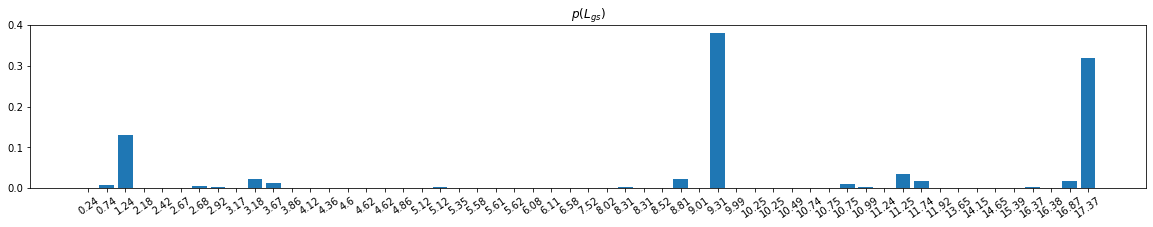

In [7]:
plt.subplots(1,figsize=(20,3))
output_prob = np.array([(o,np.mean(trace.posterior.linear_gs_0==o).values) for o in np.unique(trace.posterior.linear_gs_0)])
plt.bar(x=range(np.unique(trace.posterior.linear_gs_0).size),height=output_prob[:,1])
plt.xticks(range(np.unique(trace.posterior.linear_gs_0).size), np.round(output_prob[:,0],2),rotation=35)
plt.title('$p(L_{gs})$');

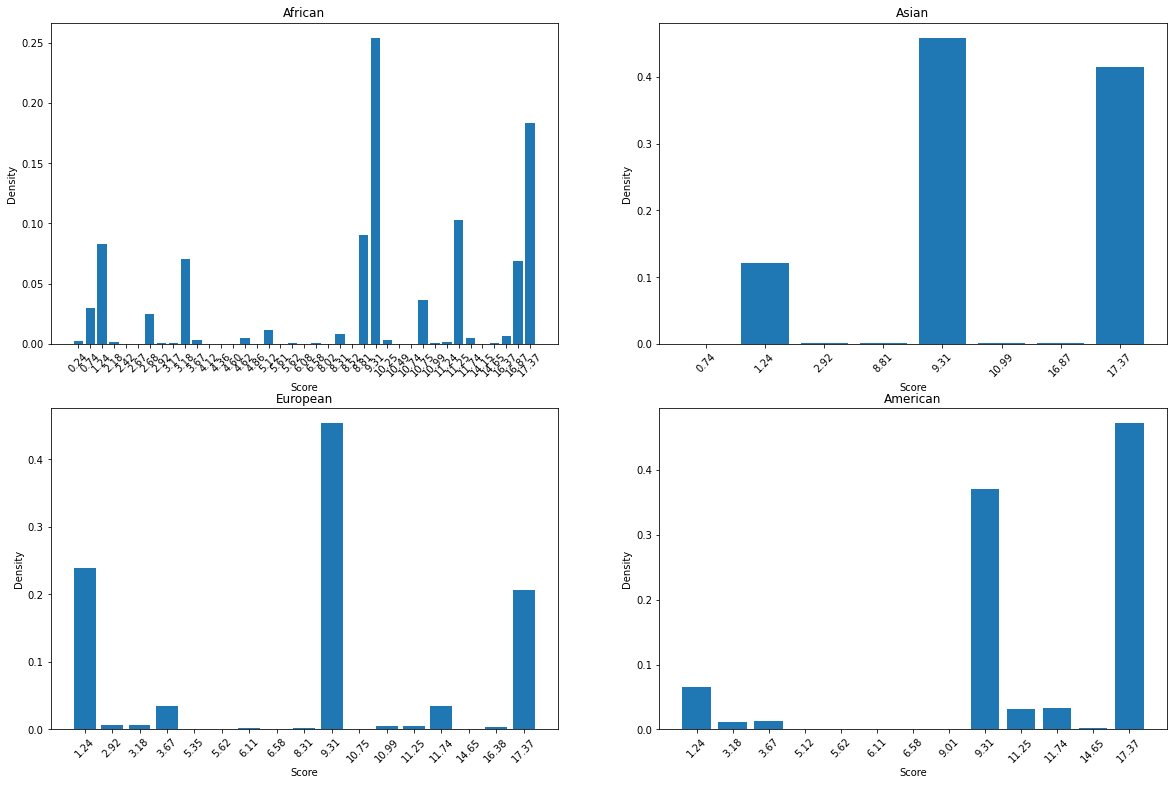

In [8]:
ethnicity = ["African", "Asian", "European", "American"]

fig, ax = plt.subplots(2, 2, figsize=(20, 13))
plt.xticks(rotation=45)
for country in range(0, 4):
    axs = ax[int(country/2), country%2]
    axs.set_title(ethnicity[country])
    axs.set_ylabel("Density")
    axs.set_xlabel("Score")
    values, height = np.unique(trace.posterior['linear_gs_0'][0, trace.posterior['ethnicity_'+str(0)][0].values==country], return_counts=True)
    axs.bar(list(map("{:.2f}".format, values)), height/np.sum(height))
    for tick in axs.get_xticklabels():
        tick.set_rotation(45)

# Non-linear Genetic Score

Privacy-wise, the score isn't much different from linear genetic score, it only provides capabitiy to assign weights to different genes.

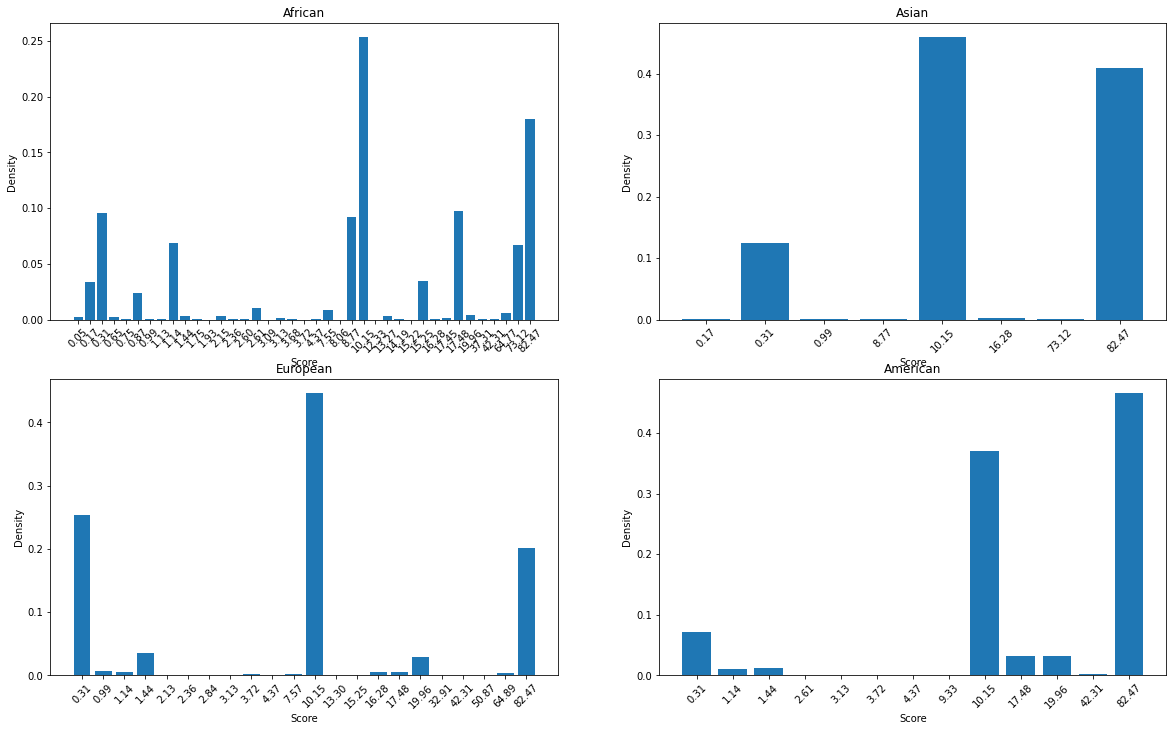

In [8]:
ethnicity = ["African", "Asian", "European", "American"]
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
plt.xticks(rotation=45)
for country in range(0, 4):
    axs = ax[int(country/2), country%2]
    axs.set_title(ethnicity[country])
    values, height = np.unique(trace.posterior['nonlinear_gs_0'][0, trace.posterior['ethnicity_'+str(0)][0].values==country], return_counts=True)
    axs.bar(list(map("{0:.2f}".format, values)), height/np.sum(height))
    axs.set_ylabel("Density")
    axs.set_xlabel("Score")
    for tick in axs.get_xticklabels():
        tick.set_rotation(45)

# Non-linear genetic score with noise

With the help of added noise Genetic score becomes continuous.

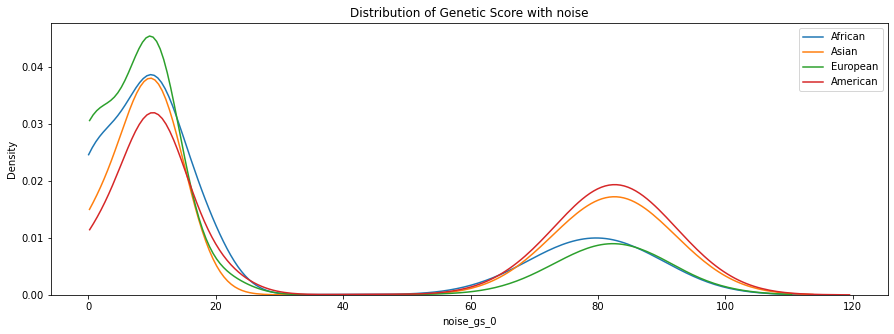

In [178]:
fig, ax = plt.subplots(1, figsize=(15, 5))
for country in range(0, 4):
    sns.kdeplot(trace.posterior['noise_gs_0'][0, trace.posterior['ethnicity_'+str(0)][0].values==country], cut=0, legend=True, ax=ax)
ax.legend(labels=["African", "Asian", "European", "American"])
ax.set_title("Distribution of Genetic Score with noise")
plt.show()

# Analysis

### Assumptions
In the analysis stage we assume that attacker has perfect knowledge of the population genetics (because they were published along with the analysis, or he looked them up from a large database like dbSNP) and the anonymisation algorithm used (presumably because it is also published or the standard in the field). We can also perform similar analysis where attackers knowledge is less perfect, but that requires more assumptions about what attacker may or may not know, and is harder to explain in this demonstration.

# Privacy Risk Metrics


First we define plotting functions for all metrics

In [9]:
def program_privacy_heatmap(secret_samples, output_samples, ax, 
                            cmap="YlGnBu", fmt=".2f", annot=True, cbar=True, 
                            cbar_kws=None):
    distinct_outputs = np.unique(output_samples) # we could define a fix domain instead of depending on the sample
    sns.heatmap(np.array([ [ np.mean((secret_samples==j)&(output_samples==o)) for j in ETHNICITIES] 
                            for o in distinct_outputs ]).T,
                annot=annot,cbar=cbar,fmt=fmt,cmap=cmap,ax=ax,cbar_kws=cbar_kws)

def val_probs(vals):
    return np.array([np.count_nonzero(vals==i)/vals.size for i in ETHNICITIES])

def output_privacy_heatmap(secret_samples, output_samples, ax, 
                            cmap="YlGnBu", fmt=".2f", annot=True, cbar=True, 
                            cbar_kws=None):
    distinct_outputs = np.unique(output_samples) # we could define a fix domain instead of depending on the sample
    sns.heatmap(np.array([val_probs(np.concatenate([secret_samples[j][(output_samples==o)[j]].values for j in range(output_samples.shape[0])])) for o in distinct_outputs]).T,
                annot=annot,cbar=cbar,fmt=fmt,cmap=cmap,ax=ax,cbar_kws=cbar_kws)

def bayes_risk(secret_samples,output_samples):
    outputs = np.unique(output_samples)
    secrets = np.unique(secret_samples)
    return sum([max([np.mean((output_samples==o)&(secret_samples==s)) for s in secrets]) for o in outputs])


In [10]:
program_traces = [trace.posterior.tas2r38_phenotype_0, 
                  trace.posterior.tas2r16_phenotype_0,
                  trace.posterior.linear_gs_0,
                  trace.posterior.linear_gs_0+np.random.normal(loc=0,scale=0.1,size=trace.posterior.linear_gs_0.shape),
                  trace.posterior.linear_gs_0+np.random.normal(loc=0,scale=0.5,size=trace.posterior.linear_gs_0.shape),
                  trace.posterior.linear_gs_0+np.random.normal(loc=0,scale=1,size=trace.posterior.linear_gs_0.shape),
                  trace.posterior.linear_gs_0+np.random.normal(loc=0,scale=2,size=trace.posterior.linear_gs_0.shape),
                  trace.posterior.linear_gs_0+np.random.normal(loc=0,scale=5,size=trace.posterior.linear_gs_0.shape),
                  trace.posterior.linear_gs_0+np.random.normal(loc=0,scale=10,size=trace.posterior.linear_gs_0.shape)]

In [11]:
program_names = ['$Ph^{r38}$', 
                 '$Ph^{r16}$',
                 '$L_{gs}$',
                 '$NL_{gs,\sigma=0.1}$',
                 '$NL_{gs,\sigma=0.5}$',
                 '$NL_{gs,\sigma=1}$',
                 '$NL_{gs,\sigma=2}$',
                 '$NL_{gs,\sigma=5}$',
                 '$NL_{gs,\sigma=10}$']
program_ids = range(len(program_names))

## Output Privacy

Program output measures the risk of learning ethnicity by observing the output of a disclosure program

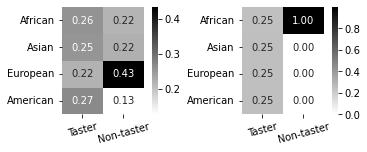

In [12]:
fig, axs = plt.subplots(1,2,figsize=(5,2),constrained_layout=True)
for i in range(2):
    output_privacy_heatmap(trace.posterior.ethnicity_0,program_traces[i],axs[i],cmap='gray_r')
    axs[i].set_xticklabels(['Taster','Non-taster'],rotation=15)
    axs[i].set_yticklabels(ethnicity_names,rotation=0)

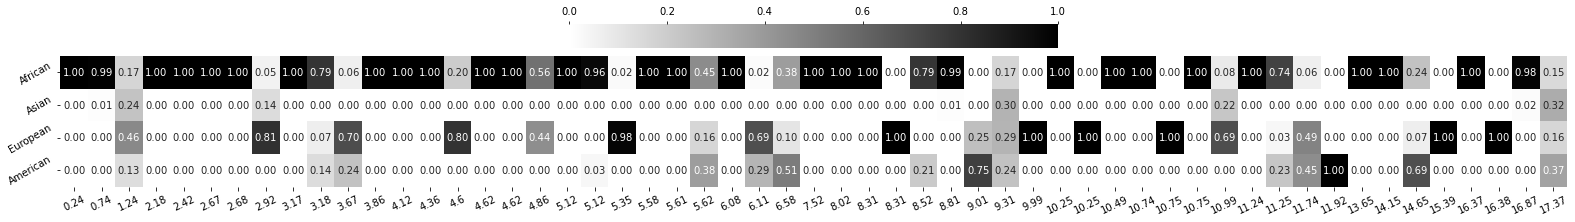

In [14]:
fig, ax = plt.subplots(1,figsize=(27,3))
output_privacy_heatmap(trace.posterior.ethnicity_0,program_traces[2],ax,cbar_kws={'location': 'top'},cmap='gray_r')
ax.set_xticklabels(np.round(np.unique(program_traces[2]),2),rotation=25)
ax.set_yticklabels(ethnicity_names,rotation=30)
plt.savefig('figures/conditional_lgs.pdf');

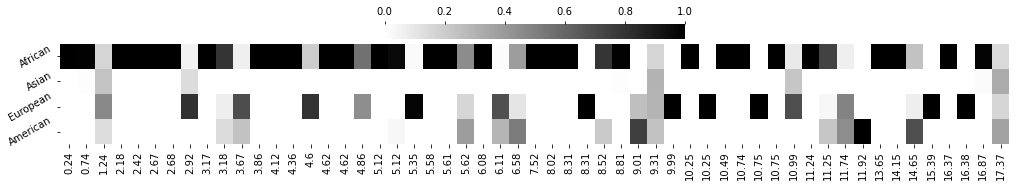

In [25]:
## Plot version for the paper
fig, ax = plt.subplots(1,figsize=(14,2.5), constrained_layout=True)
output_privacy_heatmap(trace.posterior.ethnicity_0,program_traces[2],
                       ax,cbar_kws={'location': 'top'},cmap='gray_r',
                       annot=False)
ax.set_xticklabels(np.round(np.unique(program_traces[2]),2),rotation=90)
ax.set_yticklabels(ethnicity_names,rotation=30);
plt.savefig('figures/conditional_lgs_no_annotations.pdf');

/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be use

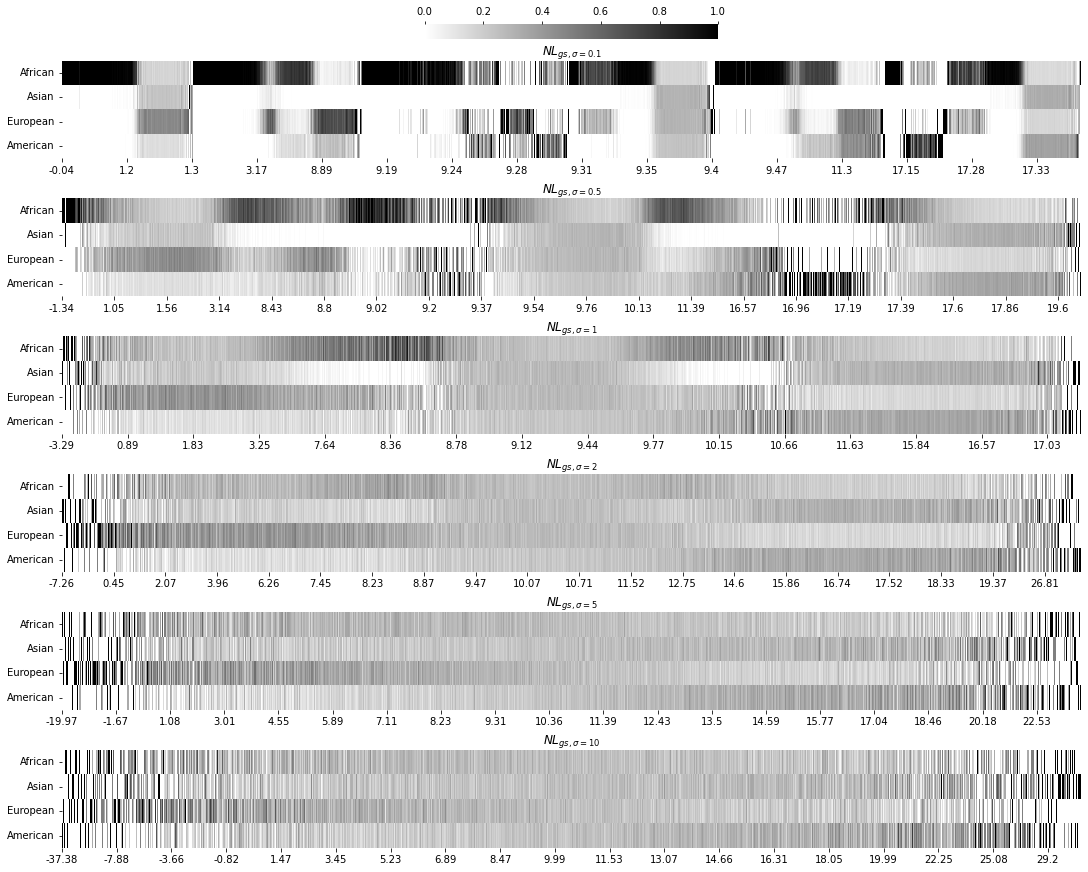

In [16]:
# fig, ax = plt.subplots(1,figsize=(30,2),constrained_layout=True)
# ax.set_xticks([]);
# ax.set_yticklabels(ethnicity_names,rotation=0);
offset_plots=3
fig, axes = plt.subplots(len(program_names)-offset_plots,figsize=(15,2*(len(program_names)-offset_plots)),constrained_layout=True)
for i in range(0,len(program_names)-offset_plots):
# i=0
    output_privacy_heatmap(trace.posterior.ethnicity_0,np.round(program_traces[i+3],2),axes[i],#ax,
                           annot=False,cbar_kws={'location': 'top'},cmap='gray_r',
                           cbar=(i==0))
    num_xticks=20    
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(num_xticks))
    pos=np.linspace(num=num_xticks,start=0,stop=np.unique(program_traces[i+3]).shape[0]-1,dtype=np.int64)    
    val=np.round(np.unique(program_traces[i+3])[pos],2) 
    axes[i].set_xticklabels(val,rotation=0)
    axes[i].set_yticklabels(ethnicity_names,rotation=0)
    
    axes[i].set_title(program_names[i+3]);
plt.savefig('output_privacy_noisy.pdf')

## Program Privacy


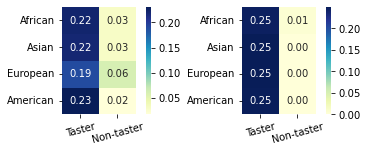

In [241]:
fig, axs = plt.subplots(1,2,figsize=(5,2),constrained_layout=True)
for i in np.arange(2):
    program_privacy_heatmap(trace.posterior.ethnicity_0,program_traces[i],axs[i])
    axs[i].set_xticklabels(['Taster','Non-taster'],rotation=15)
    axs[i].set_yticklabels(ethnicity_names,rotation=0)

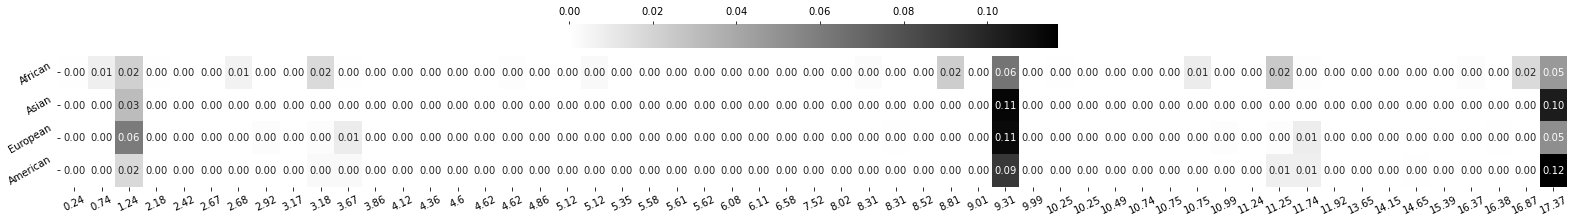

In [30]:
fig, ax = plt.subplots(1,figsize=(27,3))
program_privacy_heatmap(trace.posterior.ethnicity_0,program_traces[2],ax,cmap='gray_r',cbar_kws={'location': 'top'})
ax.set_xticklabels(np.round(np.unique(program_traces[2]),2),rotation=25)
ax.set_yticklabels(ethnicity_names,rotation=30)
plt.savefig('figures/joint_lgs.pdf')

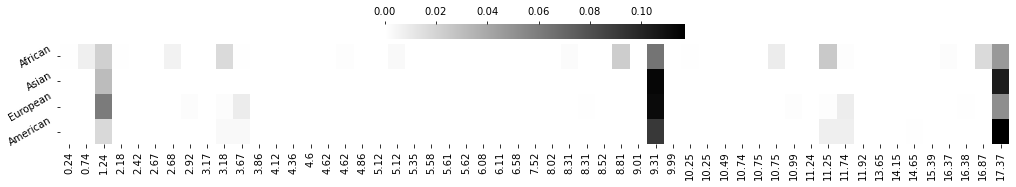

In [26]:
## Plot version for the paper
fig, ax = plt.subplots(1,figsize=(14,2.5), constrained_layout=True)
program_privacy_heatmap(trace.posterior.ethnicity_0,program_traces[2],
                       ax,cbar_kws={'location': 'top'},cmap='gray_r',
                       annot=False)
ax.set_xticklabels(np.round(np.unique(program_traces[2]),2),rotation=90)
ax.set_yticklabels(ethnicity_names,rotation=30);
plt.savefig('figures/joint_lgs_no_annotations.pdf');

/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
/home/pardo/programs/miniconda3/envs/prpro1/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be use

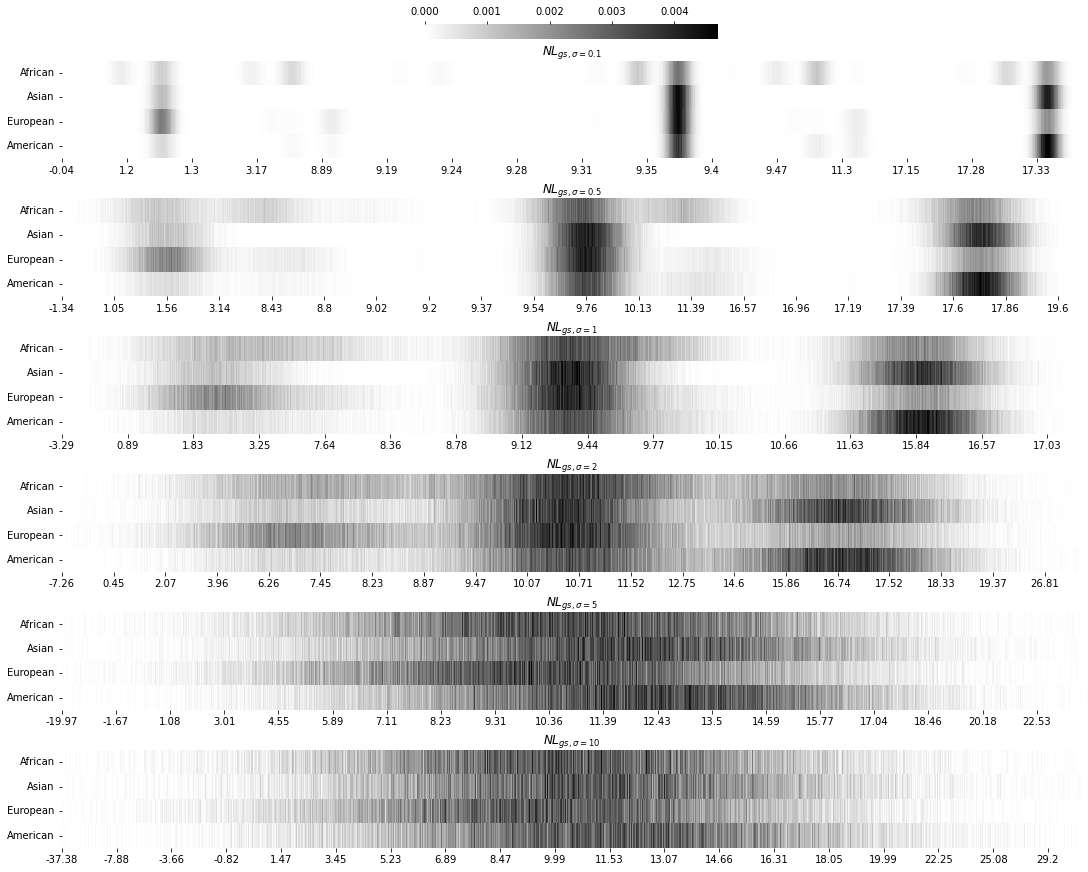

In [17]:
# fig, ax = plt.subplots(1,figsize=(30,2),constrained_layout=True)
# ax.set_xticks([]);
# ax.set_yticklabels(ethnicity_names,rotation=0);
offset_plots=3
fig, axes = plt.subplots(len(program_names)-offset_plots,figsize=(15,2*(len(program_names)-offset_plots)),constrained_layout=True)
for i in range(0,len(program_names)-offset_plots):
# i=0
    program_privacy_heatmap(trace.posterior.ethnicity_0,np.round(program_traces[i+3],2),axes[i],#ax,
                           annot=False,cbar_kws={'location': 'top'},cmap='gray_r',
                           cbar=(i==0))
    num_xticks=20    
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(num_xticks))
    pos=np.linspace(num=num_xticks,start=0,stop=np.unique(program_traces[i+3]).shape[0]-1,dtype=np.int64)    
    val=np.round(np.unique(program_traces[i+3])[pos],2) 
    axes[i].set_xticklabels(val,rotation=0)
    axes[i].set_yticklabels(ethnicity_names,rotation=0)
    
    axes[i].set_title(program_names[i+3]);
plt.savefig('program_privacy_noisy.pdf')

## Maximum (output/program) privacy risk

In [14]:
def max_program_privacy_risk(secret_samples,output_samples):
    outputs = np.unique(output_samples)
    secrets = np.unique(secret_samples)
    return np.max([[np.mean((output_samples==o)&(secret_samples==s)) for s in secrets] for o in outputs])

def max_output_privacy_risk(secret_samples,output_samples):
    outputs = np.unique(output_samples)
    secrets = np.unique(secret_samples)
    return np.max([val_probs(np.concatenate([secret_samples[j][(output_samples==o)[j]].values for j in range(output_samples.shape[0])])) for o in outputs])

In [16]:
num_programs = 9
max_output_privacy_risks = [ max_output_privacy_risk(trace.posterior.ethnicity_0,np.round(program_traces[i],2)) for i in np.arange(num_programs)]
# max_program_privacy_risks = [ max_program_privacy_risk(trace.posterior.ethnicity_0,np.round(program_traces[i],2)) for i in np.arange(num_programs)]

([<matplotlib.axis.XTick at 0x7f727336c490>,
 [Text(0, 0, '$Ph^{r38}$'),
  Text(1, 0, '$Ph^{r16}$'),
  Text(2, 0, '$L_{gs}$'),
  Text(3, 0, '$NL_{gs,\\sigma=0.1}$'),
  Text(4, 0, '$NL_{gs,\\sigma=0.5}$'),
  Text(5, 0, '$NL_{gs,\\sigma=1}$'),
  Text(6, 0, '$NL_{gs,\\sigma=2}$'),
  Text(7, 0, '$NL_{gs,\\sigma=5}$'),
  Text(8, 0, '$NL_{gs,\\sigma=10}$')])

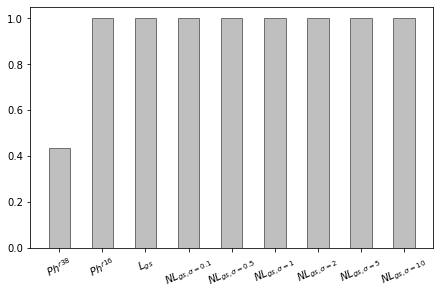

In [17]:
# ys = [max_output_privacy_risks,max_program_privacy_risks]
# titles = ['max output privacy risk $\max(p(E \mid O))$', 'max program privacy risk $\max(p(E,O))$']

plt.subplots(1,constrained_layout=True)
plt.bar(np.arange(num_programs),
        max_output_privacy_risks,
        color='gray',edgecolor='k',
        alpha=.5,
        width=.5)
plt.xticks(np.arange(num_programs),
           [program_names[i] for i in np.arange(num_programs)],
           rotation=25)
# plt.title('max output privacy risk $\max(p(E \mid O))$')
# plt.savefig('figures/max_output_privacy_risk.pdf')

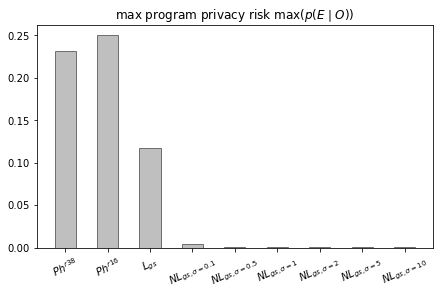

In [42]:
plt.subplots(1,constrained_layout=True)
plt.bar(np.arange(num_programs),
        max_program_privacy_risks,
        color='gray',edgecolor='k',
        alpha=.5,
        width=.5)
plt.xticks(np.arange(num_programs),
           [program_names[i] for i in np.arange(num_programs)],
           rotation=25)
plt.title('max program privacy risk $\max(p(E \mid O))$')
plt.savefig('figures/max_program_privacy_risk.pdf')



## Program Privacy Score (Bayes vulnerability)

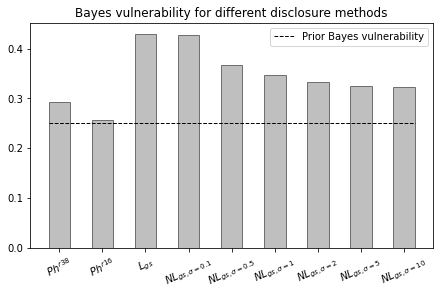

In [8]:
num_programs = 9
bayes_vulnerabilities = [ bayes_risk(trace.posterior.ethnicity_0,np.round(program_traces[i],2)) for i in np.arange(num_programs)]

plt.subplots(1,constrained_layout=True)
plt.bar(np.arange(num_programs),
        bayes_vulnerabilities,
        color='gray',edgecolor='k',
        alpha=.5,
        width=.5)
plt.hlines(y=0.25,xmin=-0.25,xmax=num_programs-1+0.25,
        ls='--',color='k',lw=1,
        label='Prior Bayes vulnerability')
plt.xticks(np.arange(num_programs),
           [program_names[i] for i in np.arange(num_programs)],
           rotation=25)
plt.legend()
plt.title('Bayes vulnerability for different disclosure methods');
# plt.savefig('figures/bayes_vulnerability.pdf')


In [85]:
num_programs = len(max_output_privacy_risks)

values = np.concatenate([np.array([b.values for b in bayes_vulnerabilities]), np.array(max_output_privacy_risks)])
metrics = np.concatenate([np.repeat('Bayes vulnerability',num_programs),np.repeat('Max output privacy',num_programs)])
progs = np.concatenate([program_names,program_names])

df2 = pd.DataFrame({'metrics': metrics,
                    'values': values,
                    'programs': progs })
df2

,metrics,values,programs
0,Bayes vulnerability,0.291575,$Ph^{r38}$
1,Bayes vulnerability,0.255670,$Ph^{r16}$
2,Bayes vulnerability,0.430260,$L_{gs}$
3,Bayes vulnerability,0.427118,"$NL_{gs,\sigma=0.1}$"
4,Bayes vulnerability,0.367360,"$NL_{gs,\sigma=0.5}$"
5,Bayes vulnerability,0.345915,"$NL_{gs,\sigma=1}$"
6,Bayes vulnerability,0.333663,"$NL_{gs,\sigma=2}$"
7,Bayes vulnerability,0.324560,"$NL_{gs,\sigma=5}$"
8,Bayes vulnerability,0.322025,"$NL_{gs,\sigma=10}$"
9,Max output privacy,0.434896,$Ph^{r38}$


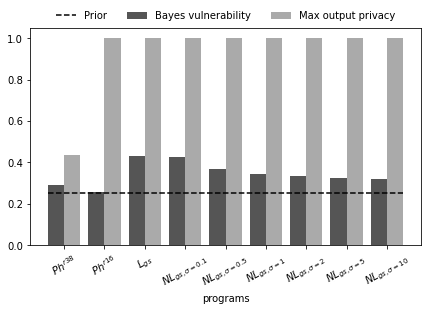

In [108]:
fig,ax=plt.subplots(figsize=(7,4))
sns.barplot(data=df2, hue='metrics', x='programs', y='values', ax=ax, palette='gray')
ax.hlines(y=0.25, xmin=-.4,  xmax=8.4, label='Prior', ls='--', color='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_ylabel('')
ax.legend(loc='upper center', ncol=3, fancybox=False, bbox_to_anchor=(.5, 1.12), edgecolor='white');
plt.savefig('figures/bayes_vulnerability_and_max_output_privacy.pdf');

## Convenience plots for the paper

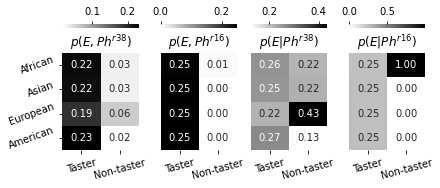

In [27]:
### Joint distribution phenotype, ethnicity
fig,ax= plt.subplots(1,4,figsize=(6,2.5),constrained_layout = True)

sns.heatmap(np.array([[ np.mean((trace.posterior.ethnicity_0==j)&(trace.posterior.tas2r38_phenotype_0==o)) for j in range(4)] for o in range(2)]).T,
            annot=True,fmt=".2f",cmap="gray_r",ax=ax[0],
            cbar_kws={'location': 'top'})
ax[0].set_title('$p(E,Ph^{r38})$')
ax[0].set_xticklabels(['Taster','Non-taster'],rotation=15)
ax[0].set_yticklabels(ethnicity_names,rotation=20);

sns.heatmap(np.array([[ np.mean((trace.posterior.ethnicity_0==j)&(trace.posterior.tas2r16_phenotype_0==o)) for j in range(4)] for o in range(2)]).T,
            annot=True,fmt=".2f",cmap="gray_r",ax=ax[1],
            cbar_kws={'location': 'top'})
ax[1].set_title('$p(E,Ph^{r16})$')
ax[1].set_xticklabels(['Taster','Non-taster'],rotation=15)
# ax[1].set_yticklabels(ethnicity_names,rotation=30);
ax[1].set_yticks([]);


### Conditional distribution ethnicity given phenotype
# fig,ax= plt.subplots(1,2,figsize=(6,3),constrained_layout = True)

sns.heatmap(np.array([val_probs(np.concatenate([trace.posterior['ethnicity_0'][j][(trace.posterior['tas2r38_phenotype_0']==o)[j]].values for j in range(trace.posterior.linear_gs_0.shape[0])])) for o in range(2)]).T,
            annot=True,fmt=".2f",cmap="gray_r",ax=ax[2],
            cbar_kws={'location': 'top'})
ax[2].set_title('$p(E | Ph^{r38})$')
ax[2].set_xticklabels(['Taster','Non-taster'],rotation=15)
# ax[2].set_yticklabels(ethnicity_names,rotation=0);
ax[2].set_yticks([]);

sns.heatmap(np.array([val_probs(np.concatenate([trace.posterior['ethnicity_0'][j][(trace.posterior['tas2r16_phenotype_0']==o)[j]].values for j in range(trace.posterior.linear_gs_0.shape[0])])) for o in range(2)]).T,
            annot=True,fmt=".2f",cmap="gray_r",ax=ax[3],
            cbar_kws={'location': 'top'})
ax[3].set_title('$p(E | Ph^{r16})$')
ax[3].set_xticklabels(['Taster','Non-taster'],rotation=15)
# ax[3].set_yticklabels(ethnicity_names,rotation=30);
ax[3].set_yticks([]);

plt.savefig('figures/phenotype.pdf')

# 4 Candidates

Their genotypes are:

1. PAV/AVI, HAPB/HAPB - Asian
2. PAV/AAI, HAPCD/HAPCD - African
3. AVI/AVI, HAPA/HAPB - European
4. PAV/PAV, HAPA/HAPA - American

This assumes attacker has perfect knowledge of the anonymisation method (genetic score), i.e. he knows the weights and how to apply them, presumably because Gregor published them. It would be interesting to see what attacker can do with imperfect knowledge. For example he knows that AVI/AVI, should give higher scores.

In [10]:
def linear_gs(tas2r38_genotype, tas2r16_genotype):
    return tas2r38_gw*tas2r38_gen2gt[tas2r38_genotype] + tas2r16_gw*tas2r16_gen2gt[tas2r16_genotype]

def nogw_gs(tas2r38_genotype, tas2r16_genotype):
    return tas2r38_gen2gt[tas2r38_genotype] + tas2r16_gen2gt[tas2r16_genotype]

def nonlinear_gs(linear_gs):
    sf1 = 1.2
    sf2 = 5
    return np.float32(linear_gs * (sf1 ** linear_gs / sf2))

def tas2r38_phenotype(genotype):
    return int(genotype == (AVI, AVI))

def tas2r16_phenotype(genotype):
    return int(genotype == (HAPCD, HAPCD))

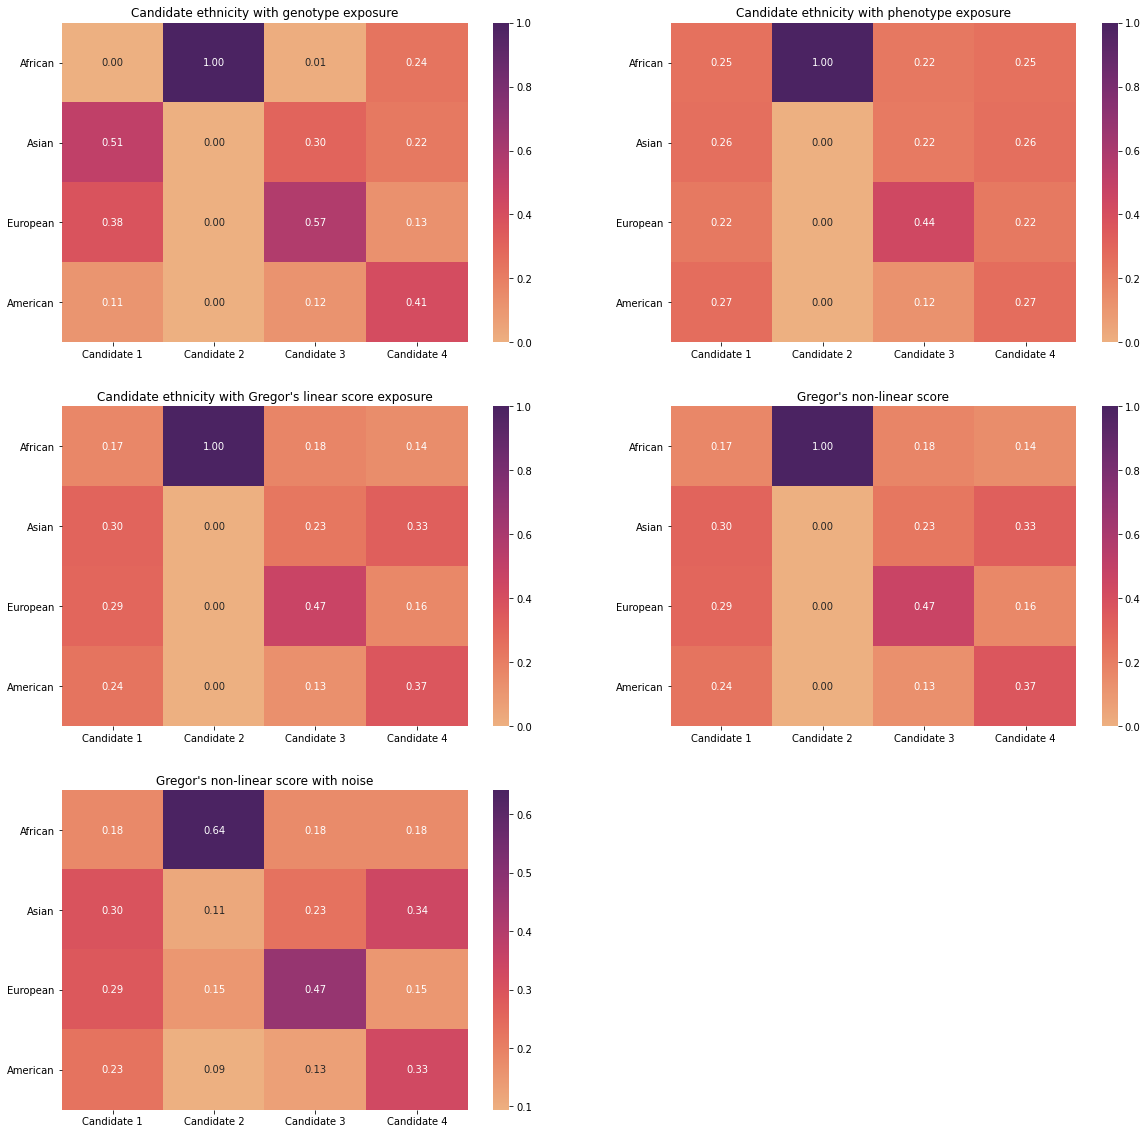

In [11]:
genotypes = [[(PAV, AVI), (HAPB, HAPB)],
             [(PAV, AAI), (HAPCD, HAPCD)],
             [(AVI, AVI), (HAPA, HAPB)],
             [(PAV, PAV), (HAPA, HAPA)]]

import math 
def heatmap(data, ax):
    sns.heatmap(data, annot=True,fmt=".2f",cmap="flare", ax=ax)
    ax.set_yticklabels(['African','Asian','European','American'], rotation=0)
    ax.set_xticklabels(["Candidate 1", 'Candidate 2', "Candidate 3", "Candidate 4"], rotation=0)
    
def lgs(candidate):
    return linear_gs(genotypes[candidate][0], genotypes[candidate][1])

fig,ax=plt.subplots(3, 2, figsize=(20,20))
ax[0, 0].set_title("Candidate ethnicity with genotype exposure")
heatmap([[np.mean(trace.posterior['ethnicity_0'][0, (trace.posterior['tas2r38_genotype_0'][0].values == genotypes[candidate][0]).all(axis=1) & (trace.posterior['tas2r16_genotype_0'][0].values == genotypes[candidate][1]).all(axis=1)] == country) for candidate in range(4)] for country in range(4)], ax[0, 0])
ax[0, 1].set_title("Candidate ethnicity with phenotype exposure")
heatmap([[np.mean(trace.posterior['ethnicity_0'][0, (trace.posterior['tas2r38_phenotype_0'][0].values == tas2r38_phenotype(genotypes[candidate][0])) & (trace.posterior['tas2r16_phenotype_0'][0].values == tas2r16_phenotype(genotypes[candidate][1]))] == country) for candidate in range(4)] for country in range(4)], ax[0, 1])
ax[1, 0].set_title("Candidate ethnicity with Gregor's linear score exposure")
heatmap([[np.mean(trace.posterior['ethnicity_0'][0, trace.posterior['linear_gs_0'][0] == lgs(candidate)] == country) for candidate in range(4)] for country in range(4)], ax[1, 0])
ax[1, 1].set_title("Gregor's non-linear score")
# The reason for funny comparison is that Gregor's non linear score runs into float32 precision issue, Pymc3 wants float32.
heatmap([[np.mean(trace.posterior['ethnicity_0'][0, (trace.posterior['nonlinear_gs_0'][0] >= nonlinear_gs(lgs(candidate))-0.001) & (trace.posterior['nonlinear_gs_0'][0] <= nonlinear_gs(lgs(candidate))+0.001)] == country) for candidate in range(4)] for country in range(4)], ax[1,1])
ax[2, 0].set_title("Gregor's non-linear score with noise")
heatmap([[np.mean(trace.posterior['ethnicity_0'][0, (trace.posterior['noise_gs_0'][0] >= nonlinear_gs(lgs(candidate))-0.1) & (trace.posterior['noise_gs_0'][0] <= nonlinear_gs(lgs(candidate))+0.1)] == country) for candidate in range(4)] for country in range(4)],ax[2,0])
fig.delaxes(ax[2, 1])

# Genotypes at greatest risk

Genotypes for those 4 candidates were picked as "worse case scenarios" for each ethnicity. With just 2 genes, it is difficult to distinguish individuals with common genotypes. However, for individuals with rarer genotypes, we can  infer the ethnicity quite well. We can turn this question upside down, and more generally ask: *Which genotypes are most vulnerable to ethnicity inference attack?*

Following is the list of genotype combinations for TAS2R38 and TAS2R16 where the attacker knowing their exact genotype can infer their associated ethnicity with at least 80% confidence. For each of those Genotype combinations there are 3 numbers, representing attackers confidence given disclosure of Genotype, Phenotype or the final version of the score with noise.

In [12]:
# tas2r38_genotype = (PAV, PAV)
# tas2r16_genotype = (HAPA, HAPA)

genotypes = list(chain(*[[(t38, t16) for t38 in tas2r38_genotypes if (PVV not in t38) and (AVV not in t38)] for t16 in tas2r16_genotypes]))
# display(genotypes)
df = pd.DataFrame(columns=['TAS2R38 Genotype', 'TAS2R16 Genotype', 'Genotype', 'Phenotype', 'Score'])
i = 0

def color(x):
    if type(x) is not float or x < 0.5:
        return "background-color: white"
    if x > 0.8:
        return "background-color: red"
    if x >= 0.5:
        return "background-color: yellow"

for (t38_gtype, t16_gtype) in genotypes:
    genotype_likelihood = np.max([np.mean(trace.posterior['ethnicity_0'][0, (trace.posterior['tas2r38_genotype_0'][0].values == t38_gtype).all(axis=1) & (trace.posterior['tas2r16_genotype_0'][0].values == t16_gtype).all(axis=1)] == country) for country in range(4)])
    phenotype_likelihood = np.max([np.mean(trace.posterior['ethnicity_0'][0, (trace.posterior['tas2r38_phenotype_0'][0].values == tas2r38_phenotype(t38_gtype)) & (trace.posterior['tas2r16_phenotype_0'][0].values == tas2r16_phenotype(t16_gtype))] == country) for country in range(4)])
    score_likelihood = np.max([np.mean(trace.posterior['ethnicity_0'][0, (trace.posterior['noise_gs_0'][0] >= nonlinear_gs(linear_gs(t38_gtype, t16_gtype))-0.2) & (trace.posterior['noise_gs_0'][0] <= nonlinear_gs(linear_gs(t38_gtype, t16_gtype))+0.2)] == country) for country in range(4)])
    if genotype_likelihood > 0.8:
        df.loc[i] = [gen2name_tas2r38(t38_gtype), gen2name_tas2r16(t16_gtype), genotype_likelihood, phenotype_likelihood, score_likelihood]
        i+=1
display(df.style.applymap(color))

,TAS2R38 Genotype,TAS2R16 Genotype,Genotype,Phenotype,Score
0,PAV/PAV,HAP-CD/HAP-CD,1.000000,1.000000,0.397727
1,PAV/AVI,HAP-CD/HAP-CD,1.000000,1.000000,0.522678
2,PAV/AAV,HAP-CD/HAP-CD,1.000000,1.000000,0.766537
3,PAV/AAI,HAP-CD/HAP-CD,1.000000,1.000000,0.689922
4,AVI/AVI,HAP-CD/HAP-CD,1.000000,1.000000,0.755677
5,AVI/AAV,HAP-CD/HAP-CD,1.000000,1.000000,0.792199
6,AVI/PVI,HAP-CD/HAP-CD,1.000000,1.000000,0.561798
7,AVI/AAI,HAP-CD/HAP-CD,1.000000,1.000000,0.951952
8,AAI/AAI,HAP-CD/HAP-CD,1.000000,1.000000,0.686620
9,PAV/PAV,HAP-CD/HAP-A,0.989292,0.269156,0.314371


# Utility

Here we study the utility of the noisy linear score.

In [117]:
def utility(trace_real, trace_noisy, delta):
    return np.mean(np.round(np.abs(trace_real-trace_noisy),2)<delta).values

First we plot he distribution of absolute distance between the noisy linear score and the linear score w/o noise.

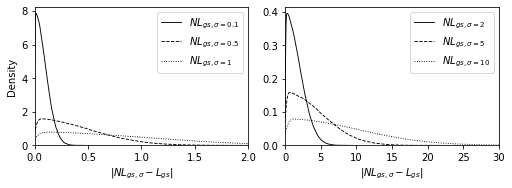

In [113]:
fig,ax = plt.subplots(1,2,figsize=(7,2.5),constrained_layout=True)
lws=["solid", "dashed", "dotted"]
[sns.kdeplot(np.abs(np.concatenate(program_traces[2]-program_traces[i])),lw=.9,ls=lws[i-3],color='k',label=program_names[i],ax=ax[0]) for i in range(3,6)];
[sns.kdeplot(np.abs(np.concatenate(program_traces[2]-program_traces[i])),lw=.9,ls=lws[i-6],color='k',label=program_names[i],ax=ax[1]) for i in range(6,9)];
ax[1].set_ylabel("")
[a.legend() for a in ax]
[a.set_xlabel('$|NL_{gs,\sigma} - L_{gs}|$') for a in ax];
ax[0].set_xlim([0,2]);
ax[1].set_xlim([0,30]);
plt.savefig('figures/utility-metric.pdf')

Now we plot our utility score, the error bound probability with $\delta=0.1$

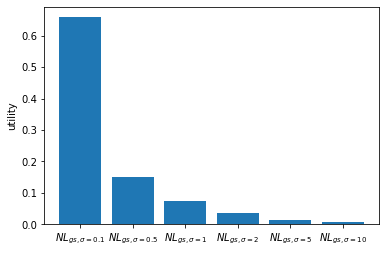

In [140]:
plt.bar(range(6),[utility(program_traces[2],program_traces[i+3],0.1) for i in  range(6)])
plt.ylabel('utility')
plt.xticks(range(6),[program_names[i] for i in range(3,9)]);

## Privacy/Utility trade-off

The following plots show the trade-off between privacy (measured as Bayes vulnerability) and utility (measured as error bound probability with different values of $\delta$)

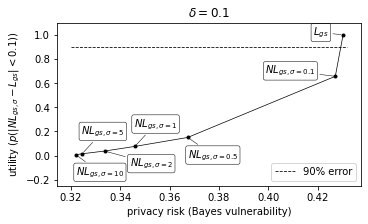

In [187]:
plt.subplots(figsize=(5,3),constrained_layout=True)
x = np.array([ v.values for v in bayes_vulnerabilities[2:]])
y = np.array([np.mean(np.round(np.abs(program_traces[2]-program_traces[i+2]),2)<0.1).values for i in  range(7)])
plt.plot(x,y,color='k',marker='.',lw=.7)

plt.ylim([-.25,1.1])

for (x,y,i) in zip(x, y, range(y.size)):
    xtext = 0
    ytext = 10
    rotation = 0
    if i==6 or i==2:
        ytext=-20
    if i==4:
        xtext=25
        ytext=-15
    if i==5 or i==3:
        ytext=20
        xtext=-1        
        rotation=0    
    if i==1:
        xtext=-70
        ytext=3
    if i==0:
        xtext=-30
        ytext=0

    plt.annotate(program_names[i+2], xy=(x,y), 
                 rotation=rotation, xytext=(xtext, ytext),
                 arrowprops=dict(facecolor='black', lw=0.5, arrowstyle="-"),
                 textcoords='offset points',
                 bbox=dict(facecolor='none', edgecolor='k', lw=0.5, boxstyle='round,pad=0.2'))

plt.hlines(y=0.9,xmin=0.32,xmax=0.432,ls='--',color='k',lw=0.8, label='90% error');
plt.ylabel('utility ($p(|NL_{gs,\sigma} - L_{gs}| < 0.1)$)')
plt.xlabel('privacy risk (Bayes vulnerability)');
# plt.title('Privacy/Utility trade-off');
plt.legend(loc='lower right')
plt.title('$\delta=0.1$')
plt.savefig('figures/privacy-utility-trade-off-01.pdf')


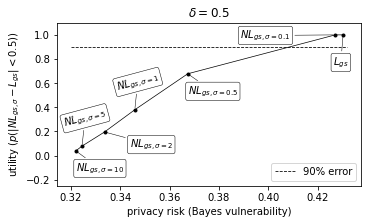

In [191]:
plt.subplots(figsize=(5,3),constrained_layout=True)
x = np.array([ v.values for v in bayes_vulnerabilities[2:]])
y = np.array([np.mean(np.round(np.abs(program_traces[2]-program_traces[i+2]),2)<0.5).values for i in  range(7)])
plt.plot(x,y,color='k',marker='.',lw=.7)

plt.ylim([-.25,1.1])

for (x,y,i) in zip(x, y, range(y.size)):
    xtext = 0
    ytext = 10
    rotation = 0
    if i==6 or i==2:
        ytext=-20
    if i==4:
        xtext=25
        ytext=-15
    if i==5 or i==3:
        ytext=20
        xtext=-20
        rotation=15    
    if i==1:
        xtext=-95
        ytext=-3
    if i==0:
        xtext=-10
        ytext=-30

    plt.annotate(program_names[i+2], xy=(x,y), 
                 rotation=rotation, xytext=(xtext, ytext),
                 arrowprops=dict(facecolor='black', lw=0.5, arrowstyle="-"),
                 textcoords='offset points',
                 bbox=dict(facecolor='none', edgecolor='k', lw=0.5, boxstyle='round,pad=0.2'))

plt.hlines(y=0.9,xmin=0.32,xmax=0.432,ls='--',color='k',lw=0.8, label='90% error');
plt.ylabel('utility ($p(|NL_{gs,\sigma} - L_{gs}| < 0.5)$)')
plt.xlabel('privacy risk (Bayes vulnerability)');
# plt.title('Privacy/Utility trade-off');
plt.legend(loc='lower right')
plt.title('$\delta=0.5$')
plt.savefig('figures/privacy-utility-trade-off-05.pdf')

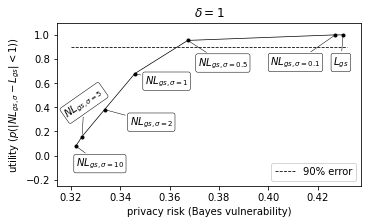

In [196]:
plt.subplots(figsize=(5,3),constrained_layout=True)
x = np.array([ v.values for v in bayes_vulnerabilities[2:]])
y = np.array([np.mean(np.round(np.abs(program_traces[2]-program_traces[i+2]),2)<1).values for i in  range(7)])
plt.plot(x,y,color='k',marker='.',lw=.7)

plt.ylim([-.25,1.1])

for (x,y,i) in zip(x, y, range(y.size)):
    xtext = 0
    ytext = 10
    rotation = 0
    if i==6:
        ytext=-20
    if i==4:
        xtext=25
        ytext=-15
    if i==5:
        ytext=20
        xtext=-20
        rotation=35    
    if i==3:
        ytext=-10
        xtext=10
        rotation=0
    if i==2:
        xtext=10
        ytext=-25
    if i==1:
        xtext=-65
        ytext=-30
    if i==0:
        xtext=-10
        ytext=-30

    plt.annotate(program_names[i+2], xy=(x,y), 
                 rotation=rotation, xytext=(xtext, ytext),
                 arrowprops=dict(facecolor='black', lw=0.5, arrowstyle="-"),
                 textcoords='offset points',
                 bbox=dict(facecolor='none', edgecolor='k', lw=0.5, boxstyle='round,pad=0.2'))

plt.hlines(y=0.9,xmin=0.32,xmax=0.432,ls='--',color='k',lw=0.8, label='90% error');
plt.ylabel('utility ($p(|NL_{gs,\sigma} - L_{gs}| < 1)$)')
plt.xlabel('privacy risk (Bayes vulnerability)');
# plt.title('Privacy/Utility trade-off');
plt.legend(loc='lower right')
plt.title('$\delta=1$')
plt.savefig('figures/privacy-utility-trade-off-1.pdf')

To increase our confidence that our results are accurate, below we generate 10 traces for each value of $\sigma$ for the noisy linear score. This will give us a sense of the variance of the results.

In [115]:
gen_noisy_ls = lambda std : np.array(trace.posterior.linear_gs_0.values+np.random.normal(0,std,size=trace.posterior.linear_gs_0.shape))

In [ ]:

priv_util = [[(bayes_risk(trace.posterior.ethnicity_0,np.round(t,2)).values,utility(trace.posterior.linear_gs_0, t, 0.1)) for t in [gen_noisy_ls(std) for i in range(10)]] for std in [0.1, 0.5, 1, 2, 5, 10]]

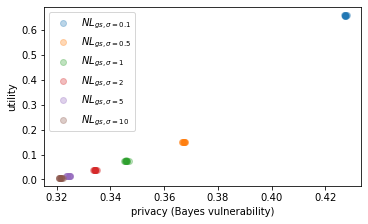

In [215]:
plt.subplots(figsize=(5,3),constrained_layout=True)
for i in range(6):
    plt.scatter(x=np.array(priv_util)[i,:,0],
                y=np.array(priv_util)[i,:,1],
                alpha=.3,
                label=program_names[i+3])
plt.legend()
plt.ylabel('utility')
plt.xlabel('privacy (Bayes vulnerability)')
plt.savefig('figures/trade-off-10-samples-per-program.pdf')

Finally, we plot the utility score value for different values of $\sigma$

In [164]:
stds = np.linspace(0,10,num=20)
uti_std01 = np.array([[(std,utility(trace.posterior.linear_gs_0, t, 0.1)) for t in [gen_noisy_ls(std) for i in range(40)]] for std in stds])
uti_std05 = np.array([[(std,utility(trace.posterior.linear_gs_0, t, 0.5)) for t in [gen_noisy_ls(std) for i in range(40)]] for std in stds])
uti_std1 = np.array([[(std,utility(trace.posterior.linear_gs_0, t, 1)) for t in [gen_noisy_ls(std) for i in range(40)]] for std in stds])

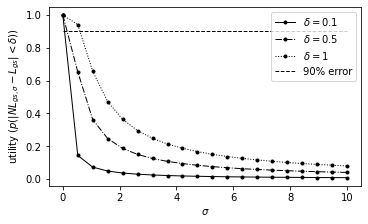

In [197]:
plt.subplots(figsize=(5,3),constrained_layout=True)
# for i in range(4,stds.size):
#     plt.scatter(x=uti_std[i,:,0],
#                 y=uti_std[i,:,1],
#                 alpha=.3)
plt.plot(stds,np.mean(uti_std01[:,:,1],axis=1),color='k',marker='.',ls='-',lw=1,label='$\delta=0.1$')
plt.plot(stds,np.mean(uti_std05[:,:,1],axis=1),color='k',marker='.',ls='-.',lw=1,label='$\delta=0.5$')
plt.plot(stds,np.mean(uti_std1[:,:,1],axis=1),color='k',marker='.',ls=':',lw=1,label='$\delta=1$')
plt.hlines(y=.9,xmin=0,xmax=10,ls='--',lw=1,color='k',label='90% error')
plt.xlabel('$\sigma$');
plt.legend();
plt.ylabel('utility ($p(|NL_{gs,\sigma} - L_{gs}| < \delta)$)')
plt.savefig('figures/trade-off-sigma-utility.pdf')

# Points for discussion
* It would be nice to perform analysis with respect to some dataset. Perhaps we can model a dataset as used by TAS2R38 paper, presuming that our hypothetical wine tasting researchers would obtain the same? (i.e. we would get population frequencies and number of individuals from there).
* We need some metrics tp quantitatively compare different scores/anonymisation techniques, since we are looking at attribute disclosure (ethnicity), perhaps something like "t-Closeness" or "δ-Disclosure privacy"? Also instead of ethnicity we could do genotype inference.
* Currently the noise is just multiplicative noise from normal distribution of mean 1, and sigma 0.1, perhaps we can apply OpenDP as another anonymisation method to get differential privacy?
* Can we objectively evaluate utility in this case?



## Diagnosis

The diagnosis indicates that the traces have converged and exhibit low autocorrelation. This indicates that the results of the analysis are accurate.

In [29]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ethnicity_0,1.496,1.118,0.000,3.000,0.003,0.002,151234.0,107156.0,1.0
tas2r38_diplotype_0[0],0.656,1.239,0.000,2.000,0.005,0.003,56448.0,53752.0,1.0
tas2r38_diplotype_0[1],0.658,1.238,0.000,2.000,0.005,0.003,56110.0,54016.0,1.0
tas2r16_diplotype_0[0],1.184,0.478,1.000,2.000,0.001,0.001,134958.0,163989.0,1.0
tas2r16_diplotype_0[1],1.184,0.476,1.000,2.000,0.001,0.001,140936.0,171182.0,1.0
noise05_0,1.000,0.050,0.906,1.094,0.000,0.000,434094.0,286995.0,1.0
noise_0,1.000,0.100,0.811,1.188,0.000,0.000,421210.0,278689.0,1.0
noise2_0,1.000,0.200,0.621,1.374,0.000,0.000,452056.0,278611.0,1.0
tas2r38_genotype_0[0],0.215,0.558,0.000,1.000,0.002,0.001,69747.0,68607.0,1.0
tas2r38_genotype_0[1],1.099,1.537,0.000,6.000,0.006,0.004,59287.0,58774.0,1.0
